In [1]:
def generate_gbm(S0, mu, sigma, T=1, dt=1/1825):
    """
    Generate a GBM path.
    
    :param S0: Initial stock price
    :param mu: Drift
    :param sigma: Volatility
    :param T: Total time (default is 1 year)
    :param dt: Time increment (default is 1/365, i.e., daily)
    :return: GBM path as a numpy array
    """
    N = int(T / dt)  # Total number of time steps
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Cumulative sum to generate Brownian motion
    
    # Calculate GBM path
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # Stock price path
    return S



In [2]:
import numpy as np
import pandas as pd

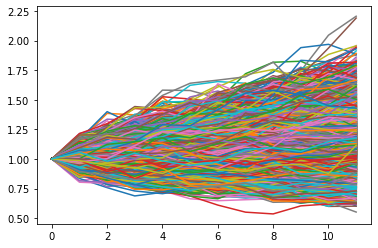

In [501]:
mu2 = []
sigma2 = []

prices = []
returns = []

N_t = 12

for i in range(10000):

    price = generate_gbm(S0=1, mu=0.109, sigma=0.1853, T=1, dt=1/N_t)
    price = pd.Series(price)
    price = price / price.iloc[0]
    ret = np.log(price / price.shift(1))
    ret = ret[1:]
    mu_= ret.mean() 
    sigma_ = ret.std()
    mu2.append(mu_)
    sigma2.append(sigma_)
    price.plot()
    
    prices.append(price)
    returns.append(ret)

In [502]:
np.mean(mu2) * N_t

0.10029079991212822

In [503]:
np.mean(sigma2) * np.sqrt(N_t)

0.1813511112615963

In [504]:

import matplotlib.pyplot as plt
import portfolio_insurance as pi
from scipy.stats import norm

In [505]:
def get_E(price, ret, vol, T, a, rf, trad_filter):
    #set the strategy params
    K = price[0] * a
    r = rf[0]
    E = []
    sigma = vol[0] * np.sqrt(N_t)
    sigma = sigma * np.sqrt(1+np.sqrt(2/np.pi)*(0.001/(sigma*np.sqrt(1/N_t))))
    
    for i in range(len(price)):
        
        t = i % (T*N_t) / N_t
        r = rf[i]
        
        if i == 0:
            d1_result = d1(price[i],K,r,sigma,T,t)
            Nd1 = norm.cdf(d1_result)
        else:
            if np.abs(ret[i-1]) > trad_filter:
                d1_result = d1(price[i],K,r,sigma,T,t)
                Nd1 = norm.cdf(d1_result)
            else:
                Nd1 = prev_Nd1

        prev_Nd1 = Nd1

        E.append(Nd1)

    return E


In [506]:
def delta_hedging(E, ret, price, rf, cost=True):
    cash = 1.0
    result = []
    
    prev_equity_invested = 0.0
    for i in range(0,len(ret)):
        equity_w = E[i-1]
        
        if i == 0:# 수익률 반영
            result.append(cash)
            
        if i != 0:
            equity_invested = equity_invested * (1+ret[i])
            cash = equity_invested + bond_invested
            result.append(cash)
        
        
        # 리밸런싱반영
        bond_w = 1 - equity_w#E[i]
        equity_invested = cash*equity_w
        bond_invested = cash*bond_w
        
        if cost:
            if  i == 0:
                sell_or_buy = cash * equity_w
            else:
                sell_or_buy = np.abs(equity_invested - prev_equity_invested)            
            equity_invested = equity_invested - sell_or_buy * (1.0/1000) #- sell_or_buy * (1/1000)
        
        r = rf[i]
        cash = equity_invested + bond_invested * (1+r/N_t)
        prev_equity_invested = equity_invested
    
    return pd.Series(result)#, index=ret.index)

In [507]:
def get_cppi(cppi_init, ret, m, f, T, rf, cost=True):
    result = []
    prev_equity_invested = cppi_init
    E_list = []
    r = rf[0]
    for j in range(len(ret)):
        if j == 0: ## 첫날
            cppi = 1.0
            B = 1 - cppi_init
            floor_value = cppi * f * np.exp(-r*T) # F0
            E_next = cppi_init * (1+ret[j])
            
        if j != 0:# 그 이후
            E = max(min(cushion * m, cppi), 0) # 내 재산 갖고 콜옵션 m개를 사자.
            B = cppi - E # 콜옵션 m개 사고 남는 돈은현금으로 갖고 있자.
            E_next = E * (1+ret[j])

        if cost:
            if  j == 0:
                sell_or_buy = cppi_init
            else:
                sell_or_buy = np.abs(E_next - prev_equity_invested)
                        
            E_next = E_next - sell_or_buy * (1.0/1000) #- sell_or_buy * (1/1000)
        
        cppi = E_next + B * (1+r/N_t)
        cushion = cppi - floor_value # 콜옵션 가격을 트래킹하는 것임.
        prev_equity_invested = E_next
        
        E_prop = E_next/(E_next+B)
        E_list.append(E_prop)
    
        result.append(cppi)
    res = pd.Series(result)#, index=ret.index)
    res = res / res.iloc[0]
    
    
            
    return res#, E_list


In [508]:
def d1(S,K,r,sigma,T,t):

    c = np.log(S/K)+(r+(sigma**2)/2)*(T-t)
    b = sigma*np.sqrt(T-t)

    return c/b

In [509]:
win = 12
T = win/12
trad_filter = 0.00


In [510]:
strategies = ['SP', 'CPPI']

In [517]:
a = { 'SP':1.0, 'CPPI': 1.0}
cost = { 'SP':False, 'CPPI':True}
func1 = { 'SP': get_E }
func2 = { 'SP': delta_hedging, 'CPPI':get_cppi }
m={'CPPI':6.2}
E, res = {}, {}
res_ret = {}
res_std = {}
for item in strategies:
    res_ret[item] = []
    res_std[item] = []

In [518]:


for i in range(len(prices)):

    price_ = prices[i][1:]
    ret_ = returns[i]
    rf_ = [0.0329] * len(returns[i])
    vol_ = [ret_.std()] * len(returns[i])

    price_ = np.array(price_)
    vol_ = np.array(vol_)
    ret_ = np.array(ret_)
    rf_ = np.array(rf_)
    price_ = price_ / price_[0]


    for item in strategies:
        if item in ['SP']:
            E[item] = func1[item](price_, ret_, vol_, T, a[item], rf_, trad_filter)
            res[item] = func2[item](E[item], ret_, price_, rf_, cost[item])

            res[item] = pd.Series(res[item])
            ret___ = np.log(res[item] / res[item].shift(1))
            ret___ = ret___[1:]
            res_ret[item].append(ret___.mean())
            res_std[item].append(ret___.std())

        elif item in ['CPPI']:
            res[item] = func2[item](E['SP'][0], ret_, m[item], a[item], T, rf_, cost)

            res[item] = pd.Series(res[item])
            ret___ = np.log(res[item] / res[item].shift(1))
            ret___ = ret___[1:]
            res_ret[item].append(ret___.mean())
            res_std[item].append(ret___.std())


#         if item in ['CPPI']:
#             plt.plot(price_, label='BH')
#             plt.plot(res['SP'], label='SP')
#             plt.plot(res['CPPI'], label='CPPI')
#             plt.legend()
#             plt.show()
#             plt.close()



In [519]:
np.mean(res_ret['SP']) * N_t

0.06542971306668427

In [520]:
np.mean(res_std['SP']) * np.sqrt(N_t)

0.11926035576004072

In [521]:
np.mean(res_ret['CPPI']) * N_t

0.0505590243489451

In [522]:
np.mean(res_std['CPPI']) * np.sqrt(N_t)

0.0616390146754678